In [1]:
# Importación librerías
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from keras import initializers
from keras import optimizers
from keras import activations
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Dropout, LSTM

from livelossplot import PlotLossesKeras
from keras.callbacks import EarlyStopping

from keras.preprocessing import sequence

from keras import optimizers, Input
from keras import backend as K
import keras.optimizers as opts

from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

import seaborn as sns

import nltk
from nltk.stem import PorterStemmer
nltk.download('wordnet')
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import CategoricalCrossentropy

from scikeras.wrappers import KerasClassifier, KerasRegressor
import re

C:\Users\SANTIAGO\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SANTIAGO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SANTIAGO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


count    7895.000000
mean      748.820899
std       494.766799
min         3.000000
25%       412.000000
50%       655.000000
75%       951.500000
max      9408.000000
Name: len, dtype: float64
(254, 6)
(17, 6)
Descripción por conteo de balabras:
count    7895.000000
mean      144.770868
std        95.816408
min         1.000000
25%        80.000000
50%       127.000000
75%       183.000000
max      1863.000000
Name: word_count, dtype: float64


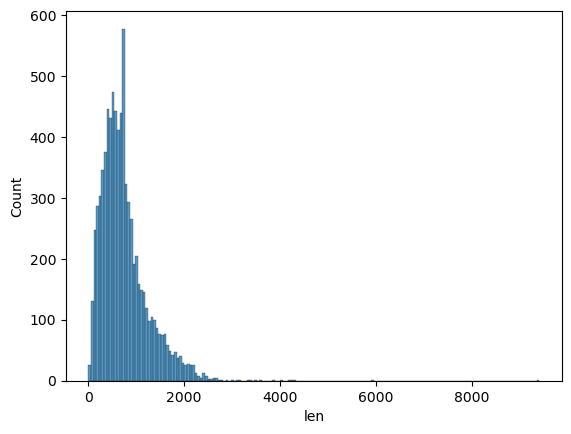

In [2]:
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTraining['len'] = dataTraining['plot'].str.len()
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)
sns.histplot(dataTraining['len'])
print(dataTraining['len'].describe())
print(dataTraining[dataTraining['len']>1900].shape)
print(dataTraining[dataTraining['len']<50].shape)

def count_words(text):
    words = text.split()
    return len(words)

# Aplicar la función a la columna 'description' y crear una nueva columna 'word_count'
print("Descripción por conteo de balabras:")
dataTraining['word_count'] = dataTraining['plot'].apply(count_words)
print(dataTraining['word_count'].describe())

In [3]:
# Definición de variable de interés (y)
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
#le = LabelEncoder()

y_genres = le.fit_transform(dataTraining['genres'])

In [4]:
#Importando diccionario de embeddings
#Se descarga de https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
#Sugerido por tutorial de keras: https://keras.io/examples/nlp/pretrained_word_embeddings/
embedding_dim = 300 #Se define la dimensión de los embeddings usados. Se eleigen entre 50, 100, 200 y 300
path_to_glove_file = r'C:\Users\SANTIAGO\MIAD\2-ML y PLN\Git\MIAD_ML_NLP_2023\Semana 7\Competencia\glove.6B.'+str(embedding_dim)+'d.txt' #Ruta donde se descomprimen los txt
embeddings_index = {} #Se guarda el diccionario de los embeddings

with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

In [5]:
#Funcion de procesamiento de texto
def procesaTexto(text,lematize =True, stemming = False):
    """
    Preprocesamiento de textos para utilizar en el modelo.

    Parametros:
    
    text(str): la cadena de texto a la que se le va a aplicar el procesamiento.
    lematize(Bool): cuando es True lematiza los verbos (default: False)
    stemming (Bool): cuando es True hace stemming a las palabras (default: False)
    """
    text = text.lower() #Pasar el texto a minúsculas
    text = re.sub(r'\b\w{1,2}\b', '', text)  # Eliminar palabras cortas
    text = re.sub(r'\d+', '', text)  # Eliminar números
    #Exclusión de stopwords
    english_stopwords = nltk.corpus.stopwords.words('english')
    words = text.split()
    words = [word for word in words if word.lower() not in english_stopwords]
    #Stemming
    if stemming == True:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]  # Aplicar stemming
    #Lematización
    if lematize ==True:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words] 
    return ' '.join(words)

#Función que obtiene los embedings de las palabras
def generaEmbedding(text):
    words = text.split()
    embeddings = []
    for word in words:
        if word in embeddings_index: #Se debe contar con el indice de embeddings
            embeddings.append(embeddings_index[word])
    if len(embeddings) == 0:
        return np.zeros(embedding_dim)  # Si la palabra no existe se rellena del tamaño de la longitud de los embeddings
    return np.mean(embeddings, axis=0)    


In [6]:
#Pre procesamiento del texto

#Para datos de entrenamiento
dataTraining['Plot Process'] = dataTraining['plot'].apply(procesaTexto) #Se aplica limpieza de texto
X_embeddings = np.array([generaEmbedding(text) for text in dataTraining['Plot Process']]) #Se consiguen los embeddings
X_train_p, X_test_p, y_train_genres_p, y_test_genres_p = train_test_split(X_embeddings, y_genres, test_size=0.2, random_state=42) #Se separan los datos

#Para datos de prueba (competencia)
dataTesting['Plot Process'] = dataTesting['plot'].apply(procesaTexto) #Se alimpia limpieza de texto
X_embeddingsTest = np.array([generaEmbedding(text) for text in dataTesting['Plot Process']]) #Se consiguen los embeddings

# Pruebas

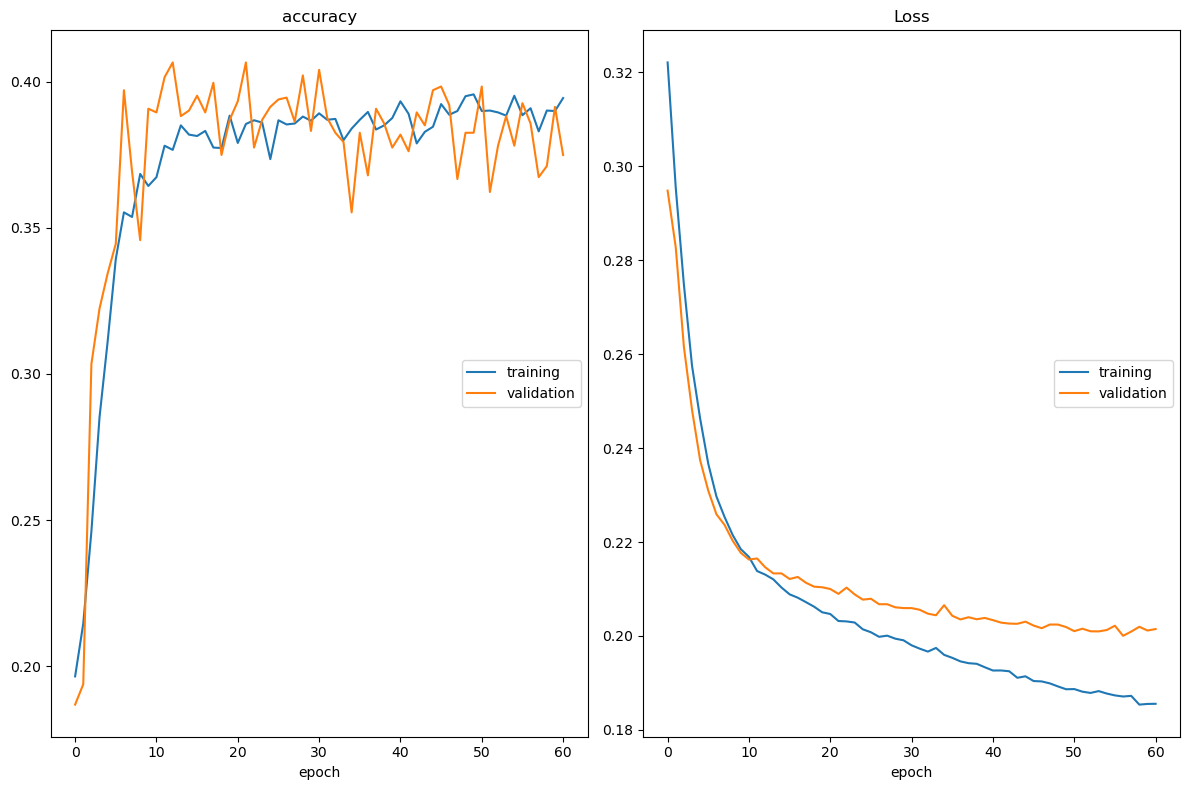

accuracy
	training         	 (min:    0.196, max:    0.396, cur:    0.394)
	validation       	 (min:    0.187, max:    0.407, cur:    0.375)
Loss
	training         	 (min:    0.185, max:    0.322, cur:    0.186)
	validation       	 (min:    0.200, max:    0.295, cur:    0.201)
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3905 - loss: 0.1852 - val_accuracy: 0.3749 - val_loss: 0.2015
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


0.8865480901056436

In [8]:
K.clear_session()
modelDep = Sequential()
modelDep.add(Dense(256, input_shape=(X_train_p.shape[1],), activation='sigmoid'))
modelDep.add(Dense(256, activation = 'sigmoid'))
modelDep.add(Dropout(0.6))    
modelDep.add(Dense(24))
modelDep.add(Activation('sigmoid'))
early_stopping = EarlyStopping(monitor="val_loss", patience = 4)
modelDep.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

modelDep.fit(X_train_p, y_train_genres_p,
                    verbose=1,
                    epochs=100,
                    callbacks=[early_stopping, PlotLossesKeras()],
                    validation_data=(X_test_p, y_test_genres_p))

# Predicción del modelo de clasificación
y_pred_genres_p = modelDep.predict(X_test_p)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres_p, y_pred_genres_p, average='macro')

#Con vector de embeddings de longitud 300: 0.8882, sin lematizar

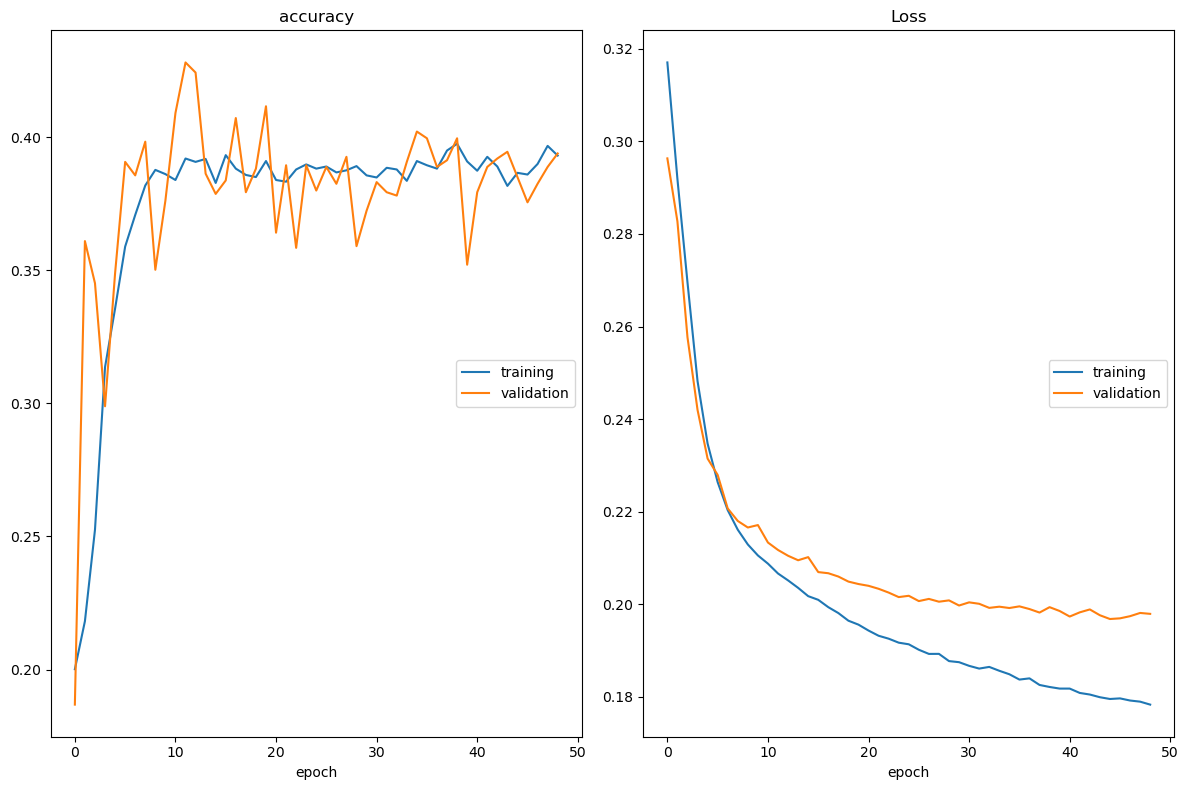

accuracy
	training         	 (min:    0.200, max:    0.398, cur:    0.393)
	validation       	 (min:    0.187, max:    0.428, cur:    0.394)
Loss
	training         	 (min:    0.178, max:    0.317, cur:    0.178)
	validation       	 (min:    0.197, max:    0.296, cur:    0.198)
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3877 - loss: 0.1814 - val_accuracy: 0.3939 - val_loss: 0.1979
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


0.8897637459714662

In [72]:
K.clear_session()
modelDep1 = Sequential()
modelDep1.add(Dense(220, input_shape=(X_train_p.shape[1],), activation='sigmoid'))
modelDep1.add(Dense(160, activation = 'sigmoid'))
modelDep1.add(Dropout(0.25))          
modelDep1.add(Dense(24))
modelDep1.add(Activation('sigmoid'))
early_stopping = EarlyStopping(monitor="val_loss", patience = 4)
modelDep1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

modelDep1.fit(X_train_p, y_train_genres_p,
                    verbose=1,
                    epochs=100,
                    callbacks=[early_stopping, PlotLossesKeras()],
                    validation_data=(X_test_p, y_test_genres_p))

# Predicción del modelo de clasificación
y_pred_genres_p1 = modelDep1.predict(X_test_p)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres_p, y_pred_genres_p1, average='macro')

## Mejor modelo hasta el momento

- Datos lematizados y un vector de 100, dos capas sigmoides de 256, droput 0.55, llegando a un performance en prueba de ROC AUC de 0.8602 (Kaggle: 0.8672)
- Datos lematizados y un vector de 300, dos capas sigmoides de 256, droput 0.6, llegando a un performance en prueba de ROC AUC de 0.8842 (Kaggle: 0.8801)
- Datos sin lematizar y un vector de 300, 1 capa sigmoide de 256, 1 capa sigmoide de 200, dropout 0.55, llegando a un performance en prueba de ROC AUC de 0.8882 (Kaggle: 0.8814)
- Datos sin lematizar y un vector de 300, 1 capa sigmoide de 256, 1 capa sigmoide de 128, dropout 0.4, llegando a un performance en prueba de ROC AUC de 0.8905 (Kaggle: 0.8845)
- Datos sin lematizar y un vector de 300, 1 capa sigmoide de 220, 1 capa sigmoide de 110, dropout 0.25, llegando a un performance en prueba de ROC AUC de 0.8919 (Kaggle: 0.8862)

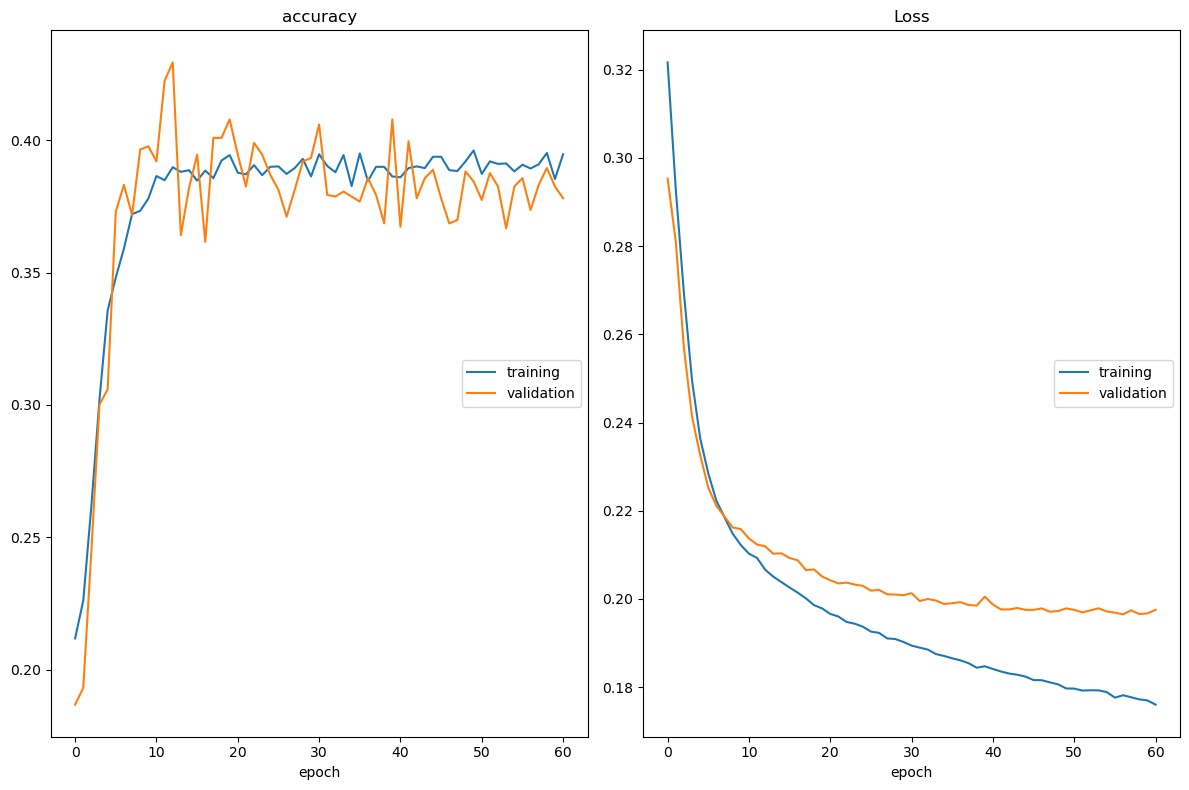

accuracy
	training         	 (min:    0.212, max:    0.396, cur:    0.395)
	validation       	 (min:    0.187, max:    0.429, cur:    0.378)
Loss
	training         	 (min:    0.176, max:    0.322, cur:    0.176)
	validation       	 (min:    0.197, max:    0.295, cur:    0.198)
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3872 - loss: 0.1764 - val_accuracy: 0.3781 - val_loss: 0.1975
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


0.8935752886346693

In [ ]:
K.clear_session()
modelDepa=Sequential()
modelDepa.add(Dense(220, input_shape=(X_train_p.shape[1],), activation='sigmoid'))
modelDepa.add(Dense(140, activation = 'sigmoid'))
modelDepa.add(Dropout(0.3))    
modelDepa.add(Dense(24))
modelDepa.add(Activation('sigmoid'))
early_stopping = EarlyStopping(monitor="val_loss", patience = 4)
modelDepa.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

modelDepa.fit(X_train_p, y_train_genres_p,
                    verbose=1,
                    epochs=100,
                    callbacks=[early_stopping, PlotLossesKeras()],
                    validation_data=(X_test_p, y_test_genres_p))

# Predicción del modelo de clasificación
y_pred_genres_p = modelDepa.predict(X_test_p)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres_p, y_pred_genres_p, average='macro')

#Con vector de embeddings de longitud 300: 0.8882, sin lematizar

# Predicción

In [73]:
#Guardar el mejor modelo
modelDepa.save('./Competencia/NN_genre.h5') 
modelDepa.save('./Competencia/NN_genre.keras') 

In [74]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

# Predicción del conjunto de test
y_pred_test_genres = modelDepa.predict(X_embeddingsTest)
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)
res.to_csv('.\Competencia\pred_genres_text_NN-Vect_Santiago6.csv', index_label='ID')
res.head()

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.000739,0.013873,0.000536,0.008188,0.593491,0.019861,0.000197,0.604923,0.018217,0.029998,...,0.022862,0.057875,0.000001,0.701605,0.001400,0.003365,0.000010,0.085298,0.001726,0.001596
4,0.065048,0.000700,0.000006,0.155877,0.144800,0.733719,0.003600,0.910962,0.000633,0.000018,...,0.001824,0.001801,0.000001,0.049125,0.000002,0.000852,0.005037,0.108976,0.001240,0.004055
5,0.041872,0.002205,0.000017,0.128927,0.093496,0.822256,0.014767,0.796269,0.001268,0.001725,...,0.000589,0.303094,0.000171,0.103326,0.000748,0.000959,0.000172,0.630712,0.001152,0.000605
6,0.189172,0.067777,0.000380,0.033432,0.089106,0.122566,0.002091,0.744476,0.001893,0.018144,...,0.000906,0.083418,0.000095,0.181350,0.073579,0.000601,0.000309,0.514807,0.030256,0.002646
7,0.003217,0.003543,0.001579,0.015260,0.164891,0.136280,0.002150,0.335116,0.008558,0.219489,...,0.003839,0.530478,0.000089,0.099539,0.049992,0.006877,0.000003,0.567952,0.000062,0.000065


# Test importación modelo prentrenado

In [67]:
from tensorflow.keras.models import load_model
# Cargar el modelo guardado
loaded_model = load_model('./Competencia/NN_genre.h5')  # Usa el enfoque que prefieras
pred_prueba_disp =  loaded_model.predict(X_embeddingsTest)
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

rueba_imp = pd.DataFrame(pred_prueba_disp, index=dataTesting.index, columns=cols)
rueba_imp.head()

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.001286,0.015319,0.001054,0.017441,0.494067,0.014902,0.000143,0.703378,0.016285,0.035612,...,0.035331,0.060607,0.000001,0.695704,0.001365,0.005212,0.000049,0.056417,0.006103,0.001590
4,0.105592,0.003396,0.000006,0.114153,0.217842,0.620026,0.011108,0.876333,0.001075,0.000032,...,0.001422,0.001674,0.000004,0.053302,0.000011,0.000441,0.005098,0.120487,0.001908,0.009353
5,0.064742,0.002929,0.000018,0.146523,0.078629,0.843643,0.021752,0.821035,0.000695,0.002161,...,0.000715,0.265763,0.000412,0.090212,0.001287,0.001584,0.000380,0.657691,0.002058,0.001084
6,0.215633,0.074904,0.000601,0.033018,0.066693,0.091503,0.001968,0.767755,0.002811,0.012272,...,0.000752,0.074605,0.000090,0.098626,0.096656,0.001218,0.000247,0.528118,0.039621,0.002668
7,0.006661,0.005868,0.001659,0.013485,0.138900,0.138407,0.000976,0.434821,0.012102,0.202888,...,0.004813,0.519295,0.000084,0.068443,0.052779,0.006351,0.000002,0.545505,0.000102,0.000088


# Disponibilización del modelo

## Función de procesamiento de datos de entrada

In [2]:
# Importación librerías

#librerias de datos
import pandas as pd
import os
import numpy as np

#librerías de procesamiento
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')

import re

from tensorflow.keras.models import load_model

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SANTIAGO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SANTIAGO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Importación librerías

#librerias de datos
import pandas as pd
import os
import numpy as np

#librerías de procesamiento
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')

import re
import joblib

from tensorflow.keras.models import load_model

#Ruta de archivos predefinidos

#Función de calculo de generos:
def PrediceGenero(text, lematize =False, stemming = False, embedding_dim = 300):
    """
    Preprocesamiento de textos para utilizar en el modelo.

    Parametros:
    
    text(str): la cadena de texto a la que se le va a aplicar el procesamiento.
    lematize(Bool): cuando es True lematiza los verbos (default: False)
    stemming (Bool): cuando es True hace stemming a las palabras (default: False)
    embedding_dim(int): dimension de los vectores de embeddings de palabras (defalut: 300)
    """
    ruta = 'C:/Users/SANTIAGO/MIAD/2-ML y PLN/Git/MIAD_ML_NLP_2023/Semana 7/Competencia/' #Ruta de los archivos
    embedding_dim = 300 #Dimensión de embeddings

    ruta_glove = ruta + 'glove.6B.'+str(embedding_dim)+'d.txt' #Para importar archivo de embeddings
    ruta_emb = ruta +'NN_genre.h5' #Para importar modelo preentrenado


    embeddings_index = {} #Se guarda el diccionario de los embeddings
    with open(ruta_glove) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    modelo_def = load_model(ruta_emb)
   
    cols = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
            'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance',
            'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']

    #Limpieza de texto
    text = text.lower() #Pasar el texto a minúsculas
    text = re.sub(r'\b\w{1,2}\b', '', text)  # Eliminar palabras cortas
    text = re.sub(r'\d+', '', text)  # Eliminar números
    #Exclusión de stopwords
    english_stopwords = nltk.corpus.stopwords.words('english')
    words = text.split()
    words = [word for word in words if word.lower() not in english_stopwords]
    #Stemming
    if stemming == True:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]  # Aplicar stemming
    #Lematización
    if lematize ==True:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words] 
    text_clean = ' '.join(words) #Texto limpio

    #Embeddings
    words = text_clean.split()
    embeddings = []
    for word in words:
        if word in embeddings_index: #Se debe contar con el indice de embeddings
            embeddings.append(embeddings_index[word])
    if len(embeddings) == 0:
        return np.zeros(embedding_dim)  # Si la palabra no existe se rellena del tamaño de la longitud de los embeddings
    
    text_embedded = np.mean(embeddings, axis=0) #Vector de embeddings del texto, promedia los valores
    text_embedded = text_embedded.reshape(1, embedding_dim)  #vector de embeddings

    #Predicción
    modelo = modelo_def
    prediccion =  modelo.predict(text_embedded)

    #Impresión
      
    dict_res = {}
    for i in range(0,len(cols)):
        dict_res[cols[i]] = prediccion[0][i].round(3)
    dict_res_Str = str(dict_res)

    return dict_res_Str


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SANTIAGO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SANTIAGO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
PrediceGenero('the true story of billy hayes ,  an american college student who is caught smuggling drugs out of turkey and thrown into prison')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


"{'Action': 0.06, 'Adventure': 0.001, 'Animation': 0.0, 'Biography': 0.156, 'Comedy': 0.152, 'Crime': 0.718, 'Documentary': 0.003, 'Drama': 0.912, 'Family': 0.001, 'Fantasy': 0.0, 'Film-Noir': 0.027, 'History': 0.005, 'Horror': 0.0, 'Music': 0.025, 'Musical': 0.002, 'Mystery': 0.002, 'News': 0.0, 'Romance': 0.05, 'Sci-Fi': 0.0, 'Short': 0.001, 'Sport': 0.005, 'Thriller': 0.099, 'War': 0.001, 'Western': 0.004}"

In [3]:
from flask import Flask
from flask_restx import Api, Resource, fields

# Definición aplicación Flask
app = Flask(__name__)

# Definición API Flask
api = Api(
    app, 
    version='1.0', 
    title='Movie Genre API',
    description='Movie genre prediction API')

ns = api.namespace('predict', 
     description='Movie genre Classifier')

# Definición argumentos o parámetros de la API
parser = api.parser()
parser.add_argument(
    'Texto', 
    type=str, 
    required=True, 
    help='Insert the description of the movie to classify', 
    location='args')

resource_fields = api.model('Resource', {
    'result': fields.String,
})

# Definición de la clase para disponibilización
@ns.route('/')
class MovieGenreApi(Resource):

    @api.doc(parser=parser)
    @api.marshal_with(resource_fields)
    def get(self):
        args = parser.parse_args()
        
        return {
         "result": PrediceGenero(args['Texto'])
        }, 200

In [4]:
app.run(debug=True, use_reloader=False, host='0.0.0.0', port=5000)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.0.8:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [25/May/2024 22:12:20] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 22:12:21] "GET /swaggerui/swagger-ui-bundle.js HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 22:12:21] "GET /swaggerui/swagger-ui.css HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 22:12:21] "GET /swaggerui/droid-sans.css HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 22:12:21] "GET /swaggerui/swagger-ui-standalone-preset.js HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 22:12:21] "GET /swagger.json HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


INFO:werkzeug:127.0.0.1 - - [25/May/2024 22:13:38] "GET /predict/?Texto=the%20true%20story%20of%20billy%20hayes%20,%20%20an%20american%20college%20student%20who%20is%20caught%20smuggling%20drugs%20out%20of%20turkey%20and%20thrown%20into%20prison HTTP/1.1" 200 -
